In [161]:
# DATA2001 Week 9 Tutorial
# Material last updated: 26 Apr 2023
# Note: this notebook was designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

In [162]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from sqlalchemy import text
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

In [163]:
regions = gpd.read_file('SA2/SA2_2021_AUST_GDA2020.shp')
business = pd.read_csv('Businesses.csv')
stops = pd.read_csv('Stops.txt')
polling_places = pd.read_csv('PollingPlaces2019.csv')
primary = gpd.read_file('catchments/catchments_primary.shp')
secondary = gpd.read_file('catchments/catchments_secondary.shp')
future = gpd.read_file('catchments/catchments_future.shp')
population = pd.read_csv('Population.csv')
income = pd.read_csv('Income.csv')

In [164]:
srid = 4326

In [165]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(text(sqlcmd), conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [166]:
db, conn = pgconnect(credentials)

Connected successfully.


In [167]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### Data cleaning of business

In [168]:
business.describe()

,sa2_code,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
count,1.221700e+04,12217.000000,12217.000000,12217.000000,12217.000000,12217.000000,12217.000000,12217.000000
mean,1.149587e+08,18.822870,22.797659,23.555947,2.980110,1.089711,1.282639,70.540313
std,8.810935e+06,51.385349,43.099939,60.411508,14.196956,6.613522,15.953875,175.595935
min,1.010210e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.080112e+08,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,8.000000
50%,1.160113e+08,8.000000,10.000000,10.000000,0.000000,0.000000,0.000000,33.000000
75%,1.220214e+08,20.000000,26.000000,26.000000,3.000000,0.000000,0.000000,80.000000
max,1.999995e+08,3589.000000,1680.000000,3782.000000,811.000000,458.000000,1504.000000,10125.000000


In [169]:
business.head(10)

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
5,A,"Agriculture, Forestry and Fishing",101021610,Googong,0,3,0,0,0,0,3
6,A,"Agriculture, Forestry and Fishing",101021611,Queanbeyan Surrounds,182,80,60,5,0,0,327
7,A,"Agriculture, Forestry and Fishing",101031013,Bombala,65,92,81,6,0,0,246
8,A,"Agriculture, Forestry and Fishing",101031014,Cooma,28,30,36,3,0,3,96
9,A,"Agriculture, Forestry and Fishing",101031015,Cooma Surrounds,91,84,73,0,0,0,251


In [170]:
print("Shape of the data:", business.shape)

Shape of the data: (12217, 11)


In [171]:
business.isnull().values.any()

False

No null values

In [172]:
print(business.groupby('industry_code').size())

industry_code
A    643
B    643
C    643
D    643
E    643
F    643
G    643
H    643
I    643
J    643
K    643
L    643
M    643
N    643
O    643
P    643
Q    643
R    643
S    643
dtype: int64


As we can see we have equal number of each category in our dataset

In [173]:
business.dtypes

industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object

In [174]:
business = business.astype({'industry_code': 'string', 'industry_name' : 'string', 'sa2_name' : 'string'})
business.dtypes

industry_code             string
industry_name             string
sa2_code                   int64
sa2_name                  string
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object

In [175]:
business.isna().sum()

industry_code             0
industry_name             0
sa2_code                  0
sa2_name                  0
0_to_50k_businesses       0
50k_to_200k_businesses    0
200k_to_2m_businesses     0
2m_to_5m_businesses       0
5m_to_10m_businesses      0
10m_or_more_businesses    0
total_businesses          0
dtype: int64

In [176]:
business.dtypes

industry_code             string
industry_name             string
sa2_code                   int64
sa2_name                  string
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object

In [177]:
business.rename(columns={
    '0_to_50k_businesses': 'from_0_to_50k',
    '50k_to_200k_businesses': 'from_50_to_200k',
    '200k_to_2m_businesses': 'from_200k_to_2m',
    '2m_to_5m_businesses': 'from_2m_to_5m',
    '5m_to_10m_businesses': 'from_5m_to_10m',
    '10m_or_more_businesses': 'from_10m_or_more',
}, inplace=True)

In [178]:
business.columns

Index(['industry_code', 'industry_name', 'sa2_code', 'sa2_name',
       'from_0_to_50k', 'from_50_to_200k', 'from_200k_to_2m', 'from_2m_to_5m',
       'from_5m_to_10m', 'from_10m_or_more', 'total_businesses'],
      dtype='object')

In [179]:
sql = """
DROP TABLE IF EXISTS business;
CREATE TABLE business (
    industry_code VARCHAR(5), 
    industry_name VARCHAR(120), 
    sa2_code INTEGER,
    sa2_name VARCHAR(120),
    from_0_to_50k INTEGER,
    from_50_to_200k INTEGER,
    from_200k_to_2m INTEGER,
    from_2m_to_5m INTEGER,
    from_5m_to_10m INTEGER,
    from_10m_or_more INTEGER,
    total_businesses INTEGER
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [180]:
business.to_sql('business', conn, if_exists='append', index=False)
query(conn, "select * from business")

,industry_code,industry_name,sa2_code,sa2_name,from_0_to_50k,from_50_to_200k,from_200k_to_2m,from_2m_to_5m,from_5m_to_10m,from_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


### Data cleaning of income

In [181]:
income.head()

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426,50,44246,61745
1,101021008,Karabar,5128,42,62946,67345
2,101021009,Queanbeyan,6778,39,61724,67276
3,101021010,Queanbeyan - East,3360,40,64010,71770
4,101021011,Queanbeyan Region,13502,44,74042,85303


In [182]:
income.dtypes

sa2_code          int64
sa2_name         object
earners          object
median_age       object
median_income    object
mean_income      object
dtype: object

In [183]:
numeric_columns = ['median_age', 'median_income', 'mean_income', 'earners']

In [184]:
for numeric_column in numeric_columns:
    try:   
        income= income.astype({numeric_column: 'float64'})
    except ValueError:
        print("Could not convert column", numeric_column)

Could not convert column median_age
Could not convert column median_income
Could not convert column mean_income
Could not convert column earners


In [185]:
for numeric_column in numeric_columns:
    income[numeric_column] = pd.to_numeric(income[numeric_column], errors='coerce')

income.isna().sum()

sa2_code         0
sa2_name         0
earners          6
median_age       6
median_income    6
mean_income      6
dtype: int64

In [186]:
for numeric_column in numeric_columns:
    try:   
        income= income.astype({numeric_column: 'float64'})
    except ValueError:
        print("Could not convert column", numeric_column)

In [187]:
income = income.dropna()
income.isna().sum()

sa2_code         0
sa2_name         0
earners          0
median_age       0
median_income    0
mean_income      0
dtype: int64

In [188]:
income.dtypes

sa2_code           int64
sa2_name          object
earners          float64
median_age       float64
median_income    float64
mean_income      float64
dtype: object

In [189]:
income = income.astype({'sa2_name' : 'string'})
income.dtypes

sa2_code           int64
sa2_name          string
earners          float64
median_age       float64
median_income    float64
mean_income      float64
dtype: object

In [190]:
sql = """
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code INTEGER,
    sa2_name VARCHAR(120),
    earners FLOAT,
    median_age FLOAT,
    median_income FLOAT,
    mean_income FLOAT
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [191]:
income.to_sql('income', conn, if_exists='append', index=False)
query(conn, "select * from income")

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426.0,50.0,44246.0,61745.0
1,101021008,Karabar,5128.0,42.0,62946.0,67345.0
2,101021009,Queanbeyan,6778.0,39.0,61724.0,67276.0
3,101021010,Queanbeyan - East,3360.0,40.0,64010.0,71770.0
4,101021011,Queanbeyan Region,13502.0,44.0,74042.0,85303.0
...,...,...,...,...,...,...
565,128021537,Royal National Park,13.0,36.0,38956.0,61645.0
566,128021538,Sutherland - Kirrawee,13698.0,41.0,62453.0,71105.0
567,128021607,Engadine,10335.0,43.0,60914.0,70158.0
568,128021608,Loftus - Yarrawarrah,4498.0,45.0,60469.0,73218.0


### Data cleaning of Population

In [192]:
population.head()

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


In [193]:
population.dtypes

sa2_code               int64
sa2_name              object
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people           int64
dtype: object

In [194]:
population.isna().sum()

sa2_code              0
sa2_name              0
0-4_people            0
5-9_people            0
10-14_people          0
15-19_people          0
20-24_people          0
25-29_people          0
30-34_people          0
35-39_people          0
40-44_people          0
45-49_people          0
50-54_people          0
55-59_people          0
60-64_people          0
65-69_people          0
70-74_people          0
75-79_people          0
80-84_people          0
85-and-over_people    0
total_people          0
dtype: int64

In [195]:
population = population.astype({'sa2_name' : 'string'})

In [196]:
population.dtypes

sa2_code               int64
sa2_name              string
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people           int64
dtype: object

In [197]:
population.describe()

,sa2_code,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,40-44_people,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
count,3.730000e+02,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.198861e+08,854.737265,890.718499,873.538874,797.010724,941.506702,1079.378016,1141.667560,1119.305630,974.163539,926.337802,860.184987,814.281501,734.670241,618.152815,541.369973,386.790885,268.656836,278.772118,14101.243968
std,6.504069e+06,457.650405,472.605070,465.615660,413.433206,513.399976,711.167860,719.999852,589.994822,453.460847,421.014390,395.336077,376.967453,352.993590,304.425028,281.331172,217.164521,159.342399,204.291009,6039.862248
min,1.020110e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.170316e+08,524.000000,544.000000,517.000000,485.000000,595.000000,578.000000,636.000000,719.000000,679.000000,645.000000,587.000000,559.000000,492.000000,410.000000,355.000000,237.000000,158.000000,122.000000,10291.000000
50%,1.210117e+08,819.000000,854.000000,861.000000,763.000000,891.000000,984.000000,1047.000000,1101.000000,960.000000,931.000000,845.000000,809.000000,703.000000,589.000000,517.000000,366.000000,260.000000,249.000000,13881.000000
75%,1.250116e+08,1157.000000,1207.000000,1182.000000,1065.000000,1219.000000,1462.000000,1506.000000,1496.000000,1314.000000,1227.000000,1138.000000,1072.000000,988.000000,837.000000,734.000000,524.000000,359.000000,403.000000,18757.000000
max,1.280216e+08,2576.000000,2576.000000,2066.000000,1771.000000,3279.000000,4586.000000,4507.000000,3664.000000,2549.000000,1924.000000,1840.000000,1737.000000,1829.000000,1675.000000,1786.000000,1362.000000,891.000000,1110.000000,25565.000000


In [198]:
# for i in range(2,21):
#     print(population.iloc[:,i].sum())
[population.iloc[:,i].sum() for i in range(2,21)]

[318817,
 332238,
 325830,
 297285,
 351182,
 402608,
 425842,
 417501,
 363363,
 345524,
 320849,
 303727,
 274032,
 230571,
 201931,
 144273,
 100209,
 103982,
 5259764]

[318817, 332238, 325830, 297285, 351182, 402608, 425842, 417501, 363363, 345524, 320849, 303727, 274032, 230571, 201931, 144273, 100209, 103982, 5259764]


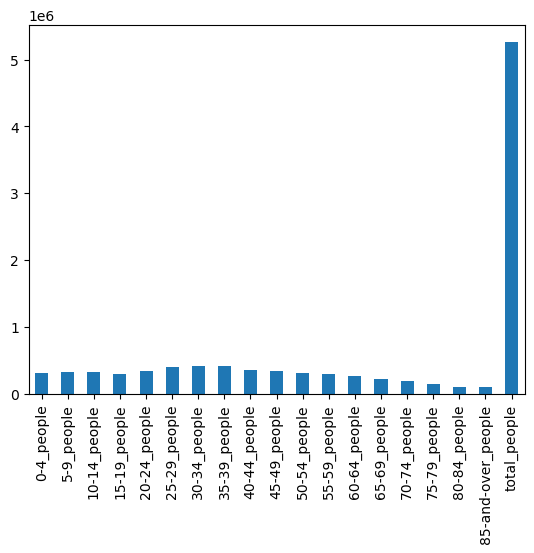

In [199]:
sums = [population.iloc[:,i].sum() for i in range(2,21)]
print(sums)
# Create a histogram of the sums
sums = population.iloc[:,2:21].sum()
sums.plot(kind='bar')
# # Show the plot
plt.show()

In [200]:
population.rename(columns={
    '0-4_people' : 'from_0_to_4',
    '5-9_people' : 'from_5_to_9',
    '10-14_people' : 'from_10_to_14',
    '15-19_people' : 'from_15_to_19',
    '20-24_people' : 'from_20_to_24',
    '25-29_people' : 'from_25_to_29',
    '30-34_people' : 'from_30_to_34',
    '35-39_people' : 'from_35_to_39',
    '40-44_people' : 'from_40_to_44',
    '45-49_people' : 'from_45_to_49',
    '50-54_people' : 'from_50_to_54',
    '55-59_people' : 'from_55_to_59',
    '60-64_people' : 'from_60_to_64',
    '65-69_people' : 'from_65_to_69',
    '70-74_people' : 'from_70_to_74',
    '75-79_people' : 'from_75_to_79',
    '80-84_people' : 'from_80_to_84',
    '85-and-over_people' : 'from_85_and_over'
}, inplace=True)

In [201]:
population.columns

Index(['sa2_code', 'sa2_name', 'from_0_to_4', 'from_5_to_9', 'from_10_to_14',
       'from_15_to_19', 'from_20_to_24', 'from_25_to_29', 'from_30_to_34',
       'from_35_to_39', 'from_40_to_44', 'from_45_to_49', 'from_50_to_54',
       'from_55_to_59', 'from_60_to_64', 'from_65_to_69', 'from_70_to_74',
       'from_75_to_79', 'from_80_to_84', 'from_85_and_over', 'total_people'],
      dtype='object')

In [202]:
sql = """
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code INTEGER,
    sa2_name VARCHAR(120),
    from_0_to_4 INTEGER,
    from_5_to_9 INTEGER,
    from_10_to_14 INTEGER,
    from_15_to_19 INTEGER,
    from_20_to_24 INTEGER,
    from_25_to_29 INTEGER,
    from_30_to_34 INTEGER,
    from_35_to_39 INTEGER,
    from_40_to_44 INTEGER,
    from_45_to_49 INTEGER,
    from_50_to_54 INTEGER,
    from_55_to_59 INTEGER,
    from_60_to_64 INTEGER,
    from_65_to_69 INTEGER,
    from_70_to_74 INTEGER,
    from_75_to_79 INTEGER,
    from_80_to_84 INTEGER,
    from_85_and_over INTEGER,
    total_people INTEGER
);
"""
query(conn, sql)
population.to_sql('population', conn, if_exists='append', index=False)
query(conn, "select * from population")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,from_0_to_4,from_5_to_9,from_10_to_14,from_15_to_19,from_20_to_24,from_25_to_29,from_30_to_34,from_35_to_39,...,from_45_to_49,from_50_to_54,from_55_to_59,from_60_to_64,from_65_to_69,from_70_to_74,from_75_to_79,from_80_to_84,from_85_and_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
1089,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
1090,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
1091,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


### Exploring Polling Places

In [203]:
polling_places.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN


In [204]:
polling_places.shape

(2930, 17)

In [205]:
polling_places.isna().sum()

FID                               0
state                             0
division_id                       0
division_name                     0
polling_place_id                  0
polling_place_type_id             0
polling_place_name                0
premises_name                     0
premises_address_1              193
premises_address_2             2816
premises_address_3             2895
premises_suburb                 115
premises_state_abbreviation       0
premises_post_code              109
latitude                        140
longitude                       140
the_geom                        140
dtype: int64

We can see that columns like "premises_address_3" and "premises_address_2" almost fully populated by Nan values. Thus, we can drop them

In [206]:
polling_places = polling_places.drop(labels=['premises_address_3', 'premises_address_2'], axis=1)


In [207]:
polling_places.isna().sum()

FID                              0
state                            0
division_id                      0
division_name                    0
polling_place_id                 0
polling_place_type_id            0
polling_place_name               0
premises_name                    0
premises_address_1             193
premises_suburb                115
premises_state_abbreviation      0
premises_post_code             109
latitude                       140
longitude                      140
the_geom                       140
dtype: int64

In [208]:
n_rows_with_nan = polling_places.isna().any(axis=1).sum()

# Print the result
print(f"Number of rows with at least one NaN value: {n_rows_with_nan}")

Number of rows with at least one NaN value: 207


In [209]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1)

,0,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,object,0
state,NSW,object,0
division_id,104,int64,0
division_name,Barton,object,0
polling_place_id,33595,int64,0
polling_place_type_id,2,int64,0
polling_place_name,Special Hospital Team 1,object,0
premises_name,Multiple sites,object,0
premises_address_1,NaN,object,193
premises_suburb,NaN,object,115


In [210]:
polling_places =  polling_places.astype({'FID' : 'string', 'state' : 'string', 'division_name' : 'string',
                                         'polling_place_name' : 'string', 'premises_name' : 'string'})

In [211]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1,)

,0,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,string,0
state,NSW,string,0
division_id,104,int64,0
division_name,Barton,string,0
polling_place_id,33595,int64,0
polling_place_type_id,2,int64,0
polling_place_name,Special Hospital Team 1,string,0
premises_name,Multiple sites,string,0
premises_address_1,NaN,object,193
premises_suburb,NaN,object,115


In [212]:
len(polling_places[polling_places['the_geom'].isna() & polling_places['premises_address_1'].isna()
               & polling_places['premises_suburb'].isna() & polling_places['premises_post_code'].isna()
               & polling_places['latitude'].isna() & polling_places['longitude'].isna()
               & polling_places['the_geom'].isna()])


109

As we can see we have 109 where all these columns have null values, so we can drop these rows

In [213]:
polling_places = polling_places.dropna(subset=['the_geom', 'premises_address_1', 'premises_suburb', 'premises_post_code', 'latitude', 'longitude'], how='all')
len(polling_places[polling_places['the_geom'].isna() & polling_places['premises_address_1'].isna()
               & polling_places['premises_suburb'].isna() & polling_places['premises_post_code'].isna()
               & polling_places['latitude'].isna() & polling_places['longitude'].isna()
               & polling_places['the_geom'].isna()])

0

In [214]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1,)

,3,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,string,0
state,NSW,string,0
division_id,109,int64,0
division_name,Calare,string,0
polling_place_id,33603,int64,0
polling_place_type_id,2,int64,0
polling_place_name,Special Hospital Team 1,string,0
premises_name,Multiple sites,string,0
premises_address_1,NaN,object,84
premises_suburb,ORANGE,object,6


In [215]:
polling_places.shape

(2821, 15)

We are additionally gonna drop rows where latitude and longitude is null

In [216]:
polling_places = polling_places.dropna(subset=['latitude', 'longitude'], how='all')

In [217]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1,)

,13,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,string,0
state,NSW,string,0
division_id,103,int64,0
division_name,Banks,string,0
polling_place_id,58,int64,0
polling_place_type_id,1,int64,0
polling_place_name,Oatley,string,0
premises_name,Oatley Public School,string,0
premises_address_1,51 Letitia St,object,67
premises_suburb,OATLEY,object,0


In [218]:
polling_places.shape

(2790, 15)

In [219]:
polling_places[polling_places['premises_address_1'].notna()]

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223.0,-33.98470,151.081000,POINT (-33.9847 151.081)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770.0,-33.74750,150.817000,POINT (-33.7475 150.817)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218.0,-33.97679,151.114897,POINT (-33.9767897 151.1148974)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221.0,-33.97560,151.111000,POINT (-33.9756 151.111)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209.0,-33.94130,151.075000,POINT (-33.9413 151.075)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,11500,1,Warilla East,Warilla-Barrack Point Surf Life Saving Club,7 Osborne Pde,WARILLA,NSW,2528.0,-34.54950,150.869000,POINT (-34.5495 150.869)
2924,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2810,1,Warilla North,Warilla North Community Centre,2-6 Hill St,WARILLA,NSW,2528.0,-34.54724,150.851770,POINT (-34.54724 150.85177)
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,BARRACK HEIGHTS,NSW,2528.0,-34.56420,150.858000,POINT (-34.5642 150.858)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,WELBY,NSW,2575.0,-34.44090,150.424000,POINT (-34.4409 150.424)


In [220]:
polling_places = polling_places.astype({'premises_address_1' : 'string', 'premises_suburb' : 'string','premises_state_abbreviation' : 'string'})

In [221]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(polling_places.latitude, polling_places.longitude)]
polling_places = polling_places.drop(['latitude','longitude'], axis=1)
polling_places = GeoDataFrame(polling_places, crs="EPSG:4326", geometry=geometry)
polling_places.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,the_geom,geometry
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223.0,POINT (-33.9847 151.081),POINT (-33.98470 151.08100)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770.0,POINT (-33.7475 150.817),POINT (-33.74750 150.81700)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218.0,POINT (-33.9767897 151.1148974),POINT (-33.97679 151.11490)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221.0,POINT (-33.9756 151.111),POINT (-33.97560 151.11100)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209.0,POINT (-33.9413 151.075),POINT (-33.94130 151.07500)


We created our own column "geometry that represent the point", so that we have correct type

In [222]:
polling_places = polling_places.drop(['the_geom'], axis=1)
polling_places.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,geometry
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223.0,POINT (-33.98470 151.08100)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770.0,POINT (-33.74750 150.81700)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218.0,POINT (-33.97679 151.11490)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221.0,POINT (-33.97560 151.11100)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209.0,POINT (-33.94130 151.07500)


In [223]:
polling_places = polling_places.astype({'premises_post_code' : 'int64'})

In [224]:
polling_places.dtypes

FID                              string
state                            string
division_id                       int64
division_name                    string
polling_place_id                  int64
polling_place_type_id             int64
polling_place_name               string
premises_name                    string
premises_address_1               string
premises_suburb                  string
premises_state_abbreviation      string
premises_post_code                int64
geometry                       geometry
dtype: object

In [225]:
polling_places.rename(columns={'geometry' : 'geom','FID' : 'fid'}, inplace=True)

In [226]:
sql = """
DROP TABLE IF EXISTS polling_places;
CREATE TABLE polling_places (
    fid VARCHAR(120),
    state VARCHAR(10),
    division_id INTEGER, 
    division_name VARCHAR(50),
    polling_place_type_id INTEGER,
    polling_place_id INTEGER,
    polling_place_name VARCHAR(120),
    premises_name VARCHAR(120),
    premises_address_1 VARCHAR(120),
    premises_suburb VARCHAR(80),
    premises_state_abbreviation VARCHAR(10),
    premises_post_code INTEGER,
    geom GEOMETRY(POINT,4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [227]:
polling_places['geom'] = polling_places['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [228]:
polling_places.to_sql('polling_places', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

790

In [229]:
query(conn, "select * from polling_places")

,fid,state,division_id,division_name,polling_place_type_id,polling_place_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,58,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223,0101000020E6100000832F4CA60AFE40C03BDF4F8D97E2...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,1,392,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770,0101000020E610000048E17A14AEDF40C0A01A2FDD24DA...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,31,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218,0101000020E6100000EA48E47107FD40C0A7EC4F3DADE3...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,67,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221,0101000020E610000022FDF675E0FC40C0643BDF4F8DE3...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,56500,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209,0101000020E6100000C6DCB5847CF840C06666666666E2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,1,2810,Warilla North,Warilla North Community Centre,2-6 Hill St,WARILLA,NSW,2528,0101000020E61000001288D7F50B4641C0D8B628B341DB...
2786,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,1,2809,Warilla South,Warilla High School,10 Keross Ave,BARRACK HEIGHTS,NSW,2528,0101000020E61000009C33A2B4374841C0FA7E6ABC74DB...
2787,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,5,58798,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,None,WARILLA,NSW,2528,0101000020E610000011F28B5C814641C0BD32141C83DB...
2788,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,1,31242,Welby,Welby Community Hall,14 Currockbilly St,WELBY,NSW,2575,0101000020E6100000386744696F3841C021B0726891CD...


# Stops

In [230]:
stops = stops.drop(['platform_code'], axis = 1)

In [231]:
stops.head(20)
stops['stop_id'] = pd.to_numeric(stops['stop_id'], errors='coerce')
stops['stop_code'] = pd.to_numeric(stops['stop_code'], errors='coerce')
temp = stops[stops['stop_code'].notna() & stops['stop_id'].notna()]
temp[temp['stop_id'].astype(int) != temp['stop_code'].astype(int)].head(5)
#stops[stops['stop_id'].astype(float).astype(string) != stops['stop_code'].astype(string)].head(5)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding


In [232]:
stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding
0,200039.0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0
1,200054.0,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0
2,200060.0,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0
3,201510.0,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0
4,201646.0,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0


In [233]:
stops = stops.drop('stop_code', axis = 1)
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding
0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0
1,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0
2,200060.0,Central Station,-33.884084,151.206292,1.0,NaN,0
3,201510.0,Redfern Station,-33.891690,151.198866,1.0,NaN,0
4,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0


In [234]:
stops = stops.dropna(subset=['stop_id'])
stops['stop_id'].isnull().sum()

0

In [235]:
stops = stops.drop('location_type', axis = 1)

In [236]:
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,parent_station,wheelchair_boarding
0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,200060,0
1,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,200060,0
2,200060.0,Central Station,-33.884084,151.206292,NaN,0
3,201510.0,Redfern Station,-33.891690,151.198866,NaN,0
4,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,201510,0


In [237]:
stops['parent_station'] = pd.to_numeric(stops['parent_station'], errors='coerce')
stops['parent_station'].isnull().sum()


59322

In [238]:
stops = stops.drop('parent_station', axis = 1)
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,wheelchair_boarding
0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,0
1,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,0
2,200060.0,Central Station,-33.884084,151.206292,0
3,201510.0,Redfern Station,-33.891690,151.198866,0
4,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,0


In [239]:
stops = stops.astype({'stop_id' : 'int64', 'stop_name' : 'string', 'stop_lat' : 'float64', 'stop_lon' : 'float64',
                        'wheelchair_boarding' : 'int64'})

In [240]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(stops.stop_lon, stops.stop_lat)]
stops = stops.drop(['stop_lat','stop_lon'], axis=1)
stops = GeoDataFrame(stops, crs="EPSG:4326", geometry=geometry)
stops.head()

In [ ]:
stops.columns

Index(['stop_id', 'stop_name', 'wheelchair_boarding', 'geometry'], dtype='object')

In [ ]:
stops.head()

,stop_id,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (-33.88221 151.20666)
1,200054,"Central Station, Eddy Av, Stand D",0,POINT (-33.88204 151.20699)
2,200060,Central Station,0,POINT (-33.88408 151.20629)
3,201510,Redfern Station,0,POINT (-33.89169 151.19887)
4,201646,"Redfern Station, Gibbons St, Stand B",0,POINT (-33.89333 151.19888)


In [ ]:
stops['geometry'] = stops['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))

/Users/joshuahallam/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [ ]:
sql = """
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    "stop_id" INTEGER PRIMARY KEY,
    "stop_name" VARCHAR(100),
    "wheelchair_boarding" INTEGER,
    "geometry" GEOMETRY(POINT,4326)
    
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})


273

In [ ]:
query(conn, "select * from stops")

,stop_id,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020E6100000A1FF6524ECF040C0FFA631FF9CE6...
1,200054,"Central Station, Eddy Av, Stand D",0,0101000020E6100000E33DC7C1E6F040C02F928BAC9FE6...
2,200060,Central Station,0,0101000020E61000008FF33DAC29F140C0817FA2F299E6...
3,201510,Redfern Station,0,0101000020E610000060304CE622F240C09E57611C5DE6...
4,201646,"Redfern Station, Gibbons St, Stand B",0,0101000020E61000003DFA6B9D58F240C0DBF9333D5DE6...
...,...,...,...,...
61268,212753,"Sydney Olympic Park Wharf, Side B",1,0101000020E61000008F52D7D537E940C0AF9B3D8185E2...
61269,2137185,"Cabarita Wharf, Side A",1,0101000020E610000089CE4C0B9BEB40C0EB409ADCBDE3...
61270,2137186,"Cabarita Wharf, Side B",1,0101000020E61000003EB375529EEB40C0C4F9BEA2BDE3...
61271,21501,Parramatta Wharf,1,0101000020E610000025C1A4032EE840C0E443E4A456E0...


### Regions

In [ ]:
regions['SA2_CODE21'] = pd.to_numeric(regions['SA2_CODE21'], errors='coerce')
regions = regions.dropna()
regions = regions.astype({'SA2_CODE21' : 'int64', 'SA2_NAME21' : 'string', 'CHG_FLAG21' : 'int64', 'CHG_LBL21' : 'string', 
                          'SA3_CODE21' : 'int64', 'SA3_NAME21' : 'string', 'SA4_CODE21' : 'int64', 'SA4_NAME21' : 'string',
                          'GCC_CODE21' : 'string', 'GCC_NAME21' : 'string', 'STE_CODE21' : 'int64', 'STE_NAME21' : 'string',
                          'AUS_CODE21' : 'string', 'AUS_NAME21' : 'string', 'LOCI_URI21' : 'string', 'AREASQKM21' : 'float64'})


In [ ]:
regions.rename(columns={'SA2_CODE21' : 'sa2_code', 'SA2_NAME21': 'sa2_name', 'CHG_FLAG21':'chg_flag', 'CHG_LBL21':'chg_lbl', 'STE_CODE21':'ste_code', 'STE_NAME21':'ste_name',
                        'AUS_CODE21':'aus_code', 'AUS_NAME21':'aus_name', 'LOCI_URI21':'loci_uri',
                        'SA3_CODE21' : 'sa3_code', 'SA3_NAME21' : 'sa3_name', 'SA4_CODE21' : 'sa4_code', 'SA4_NAME21' : 'sa4_name',
                        'GCC_CODE21' : 'gcc_code', 'GCC_NAME21' : 'gcc_name', 'STE_CODE16' : 'ste_code', 'STE_NAME16' : 'ste_name',
                        'AREASQKM21' : 'area_sqkm', 'geometry':'geom'}, inplace=True)
regions.dtypes

sa2_code        int64
sa2_name       string
chg_flag        int64
chg_lbl        string
sa3_code        int64
sa3_name       string
sa4_code        int64
sa4_name       string
gcc_code       string
gcc_name       string
ste_code        int64
ste_name       string
aus_code       string
aus_name       string
area_sqkm     float64
loci_uri       string
geom         geometry
dtype: object

In [ ]:
sql = """
DROP TABLE IF EXISTS regions;
CREATE TABLE regions (
    "sa2_code" INTEGER PRIMARY KEY,
    "sa2_name" VARCHAR(100),
    "chg_flag" INTEGER,
    "chg_lbl" VARCHAR(100),
    "sa3_code" INTEGER,
    "sa3_name" VARCHAR(100),
    "sa4_code" INTEGER,
    "sa4_name" VARCHAR(100),
    "gcc_code" VARCHAR(100),
    "gcc_name" VARCHAR(100),
    "ste_code" INTEGER,
    "ste_name" VARCHAR(100),
    "aus_code" VARCHAR(100),
    "aus_name" VARCHAR(100),
    "area_sqkm" FLOAT,
    "loci_uri" VARCHAR(150),
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [ ]:
regions['geom'] = regions['geom'].apply(lambda x: create_wkt_element(geom = x, srid =srid))

In [ ]:
regions.to_sql('regions', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "SELECT * FROM regions")

,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,area_sqkm,loci_uri,geom
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000005D...
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000002C...
2,101021610,Googong,1,New,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9164,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000006D...
3,101021611,Queanbeyan Surrounds,1,New,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3047.7057,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000200000041...
4,101031013,Bombala,0,No change,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3990.1440,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000031...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,801111141,Namadgi,0,No change,80111,Uriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,AUS,Australia,1202.7527,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000004B...
2450,901011001,Christmas Island,0,No change,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,136.1356,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000094...
2451,901021002,Cocos (Keeling) Islands,0,No change,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,13.7258,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000038000000010300000001000000CF...
2452,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000300000001030000000100000016...


In [ ]:
query(conn, "SELECT * FROM population ")

,sa2_code,sa2_name,from_0_to_4,from_5_to_9,from_10_to_14,from_15_to_19,from_20_to_24,from_25_to_29,from_30_to_34,from_35_to_39,...,from_45_to_49,from_50_to_54,from_55_to_59,from_60_to_64,from_65_to_69,from_70_to_74,from_75_to_79,from_80_to_84,from_85_and_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
742,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
743,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
744,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [ ]:
query(conn, "SELECT count(*) FROM population where total_people < 100")

,count
0,26


Filtering popluation dataset to the regions where we have more than 100 inhabitants 

In [ ]:
sql = """
DELETE FROM population
WHERE total_people < 100;
SELECT count(*) FROM population where total_people < 100;
"""
query(conn, sql)

,count
0,0


In [ ]:
sql = """
SELECT DISTINCT(gcc_name)
FROM regions
"""
query(conn, sql)

,gcc_name
0,Rest of Tas.
1,Greater Brisbane
2,Rest of Vic.
3,Rest of NSW
4,Greater Adelaide
5,Other Territories
6,Greater Darwin
7,Rest of NT
8,Australian Capital Territory
9,Rest of SA


Filtering down to only Greater SYDNEY area

In [ ]:
sql = """
DELETE FROM regions
WHERE gcc_name <> 'Greater Sydney'
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
sql = """
SELECT DISTINCT(gcc_name)
FROM regions
"""
query(conn, sql)

,gcc_name
0,Greater Sydney


### Primary

In [ ]:
primary[primary['PRIORITY'].notnull()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
657,4668,PRIMARY,Smalls Rd PS,20201221,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((151.10588 -33.79103, 151.11504 -33.7..."
777,5141,PRIMARY,Kyeemagh PS,20211221,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((151.16177 -33.94532, 151.16621 -33.9..."
1143,1943,PRIMARY,Frederickton PS,20200405,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((152.91478 -30.85309, 152.91989 -30.8..."
1507,1520,PRIMARY,Carroll PS,20200809,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((150.42887 -30.75310, 150.42995 -30.7..."


In [ ]:
primary = primary.drop(['PRIORITY'], axis=1)

In [ ]:
primary[primary['YEAR3'] != 'Y']


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
7,5148,INFANTS,Bardwell Park IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.12810 -33.93058, 151.12831 -33.9..."
96,5246,INFANTS,Bankstown SIS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.04289 -33.91783, 151.04325 -33.9..."
174,5103,INFANTS,Arncliffe WIS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.15536 -33.92675, 151.15232 -33.9..."
198,5128,INFANTS,Nillo IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.56698 -32.73101, 151.56640 -32.7..."
279,5120,INFANTS,Yeo Park IS,20140410,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.14494 -33.88995, 151.14496 -33.8..."
290,5241,INFANTS,Mt Lewis IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.04192 -33.91255, 151.04188 -33.9..."
541,5247,INFANTS,New Lambton Hts IS,20200717,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.68110 -32.93051, 151.68141 -32.9..."
591,5112,INFANTS,Taverners Hill IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.16941 -33.87425, 151.16867 -33.8..."
629,5188,INFANTS,Sefton IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((150.99655 -33.88759, 150.99653 -33.8..."
696,5104,INFANTS,Australia St IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.17700 -33.89326, 151.17725 -33.8..."


CENTRAL_PRIMARY and PRIMARY seem exactly the same in terms of the yeras they offer, and infants are all the same in being kindergarten, year 1, and year 2. therefore we're gonna drop all of the year columns as this is known from the CATCH_TYPE column



In [ ]:
primary = primary.drop(['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'], axis=1)


In [ ]:
primary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,geometry
0,2838,PRIMARY,Parklea PS,20181210,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [ ]:
primary['USE_ID'] = pd.to_numeric(primary['USE_ID'], errors='coerce')
primary['USE_ID'].isnull().sum()

0

In [ ]:
primary['ADD_DATE'] = pd.to_numeric(primary['ADD_DATE'], errors='coerce')
primary['ADD_DATE'].isnull().sum()

327

In [ ]:
primary = primary.dropna(subset=['ADD_DATE'])
primary['ADD_DATE'].isnull().sum()

0

In [ ]:
primary = primary.astype({'USE_ID' : 'int64', 'CATCH_TYPE' : 'string', 'USE_DESC' : 'string', 'ADD_DATE' : 'int64'})
primary.dtypes

USE_ID           int64
CATCH_TYPE      string
USE_DESC        string
ADD_DATE         int64
geometry      geometry
dtype: object

In [ ]:
primary.rename(columns={'USE_ID':'use_id', 'CATCH_TYPE':'catch_type', 'USE_DESC' : 'use_desc', 'ADD_DATE':'add_date', 'geometry': 'geom'}, inplace=True)
primary.dtypes

use_id           int64
catch_type      string
use_desc        string
add_date         int64
geom          geometry
dtype: object

In [ ]:
primary['geom'] = primary['geom'].apply(lambda x: create_wkt_element(geom = x, srid =srid))

In [ ]:
sql = """
DROP TABLE IF EXISTS prim;
CREATE TABLE prim (
    "use_id" INTEGER PRIMARY KEY,
    "catch_type" VARCHAR(100),
    "use_desc" VARCHAR(100),
    "add_date" INTEGER,
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
primary.to_sql('prim', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "SELECT * FROM prim")

,use_id,catch_type,use_desc,add_date,geom
0,2838,PRIMARY,Parklea PS,20181210,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223,0106000020E61000000100000001030000000100000065...
3,4185,PRIMARY,Valentine PS,20211117,0106000020E61000000100000001030000000100000029...
4,4395,PRIMARY,Mt Warrigal PS,20220619,0106000020E61000000100000001030000000100000012...
...,...,...,...,...,...
1330,2409,PRIMARY,Lismore SPS,20200616,0106000020E610000001000000010300000001000000C9...
1331,4383,PRIMARY,E A Southee PS,20200315,0106000020E610000001000000010300000001000000B9...
1332,3275,PRIMARY,Tumbarumba PS,20200507,0106000020E610000001000000010300000001000000C0...
1333,2239,PRIMARY,Jindera PS,20200507,0106000020E610000001000000010300000001000000F6...


### SECONDARY

In [ ]:
secondary['CATCH_TYPE'].unique()

array(['HIGH_COED', 'CENTRAL_HIGH', 'HIGH_GIRLS', 'HIGH_BOYS'],
      dtype=object)

In [ ]:
secondary[secondary['CATCH_TYPE'] == 'HIGH_BOYS']
secondary[secondary['CATCH_TYPE'] == 'HIGH_COED']
secondary[secondary['CATCH_TYPE'] == 'HIGH_BOYS']
secondary[secondary['CATCH_TYPE'] == 'CENTRAL_HIGH']

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
9,2675,CENTRAL_HIGH,Mungindi CS,20200121,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((149.41114 -28.69428, 149.41377 -28.6..."
72,1921,CENTRAL_HIGH,Lord Howe ICS,20210702,N,N,N,N,N,N,N,Y,N,N,N,N,N,NaN,"POLYGON ((159.06474 -31.50980, 159.06479 -31.5..."
78,1275,CENTRAL_HIGH,Boggabilla CS,20200121,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.29611 -28.54032, 150.29668 -28.5..."
79,2897,CENTRAL_HIGH,Portland CS,20200123,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.01033 -33.04637, 150.00979 -33.0..."
106,2523,CENTRAL_HIGH,Menindee CS,20191226,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((143.53702 -32.47700, 143.53691 -32.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,3555,CENTRAL_HIGH,Yeoval CS,20200604,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((148.59249 -32.44715, 148.58979 -32.4..."
425,1340,CENTRAL_HIGH,Braidwood CS,20220619,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.04779 -35.00340, 150.04940 -35.0..."
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
434,1115,CENTRAL_HIGH,Balranald CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


In [ ]:
secondary = secondary.drop(['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY'], axis=1)
secondary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,YEAR8,geometry
0,8503,HIGH_COED,Billabong HS,20200507,Y,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,Y,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,Y,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,Y,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,Y,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [ ]:
secondary['USE_ID'] = pd.to_numeric(secondary['USE_ID'], errors='coerce')
secondary['USE_ID'].isnull().sum()

0

In [ ]:
secondary['ADD_DATE'] = pd.to_numeric(secondary['ADD_DATE'], errors='coerce')
secondary['ADD_DATE'].isnull().sum()

64

In [ ]:
secondary = secondary.dropna(subset=['ADD_DATE'])
secondary['ADD_DATE'].isnull().sum()

0

In [ ]:
secondary = secondary.astype({'USE_ID' : 'int64', 'CATCH_TYPE' : 'string', 'USE_DESC' : 'string', 'ADD_DATE' : 'int64'})
secondary.dtypes

USE_ID           int64
CATCH_TYPE      string
USE_DESC        string
ADD_DATE         int64
YEAR8           object
geometry      geometry
dtype: object

In [ ]:
secondary.rename(columns={'USE_ID':'use_id', 'CATCH_TYPE':'catch_type', 'USE_DESC' : 'use_desc', 'ADD_DATE':'add_date', 'YEAR8':'year8', 'geometry': 'geom'}, inplace=True)
secondary.dtypes

use_id           int64
catch_type      string
use_desc        string
add_date         int64
year8           object
geom          geometry
dtype: object

In [ ]:
secondary['geom'] = secondary['geom'].apply(lambda x: create_wkt_element(geom = x, srid =srid))

In [ ]:
sql = """
DROP TABLE IF EXISTS secondary;
CREATE TABLE secondary (
    "use_id" INTEGER PRIMARY KEY,
    "catch_type" VARCHAR(100),
    "use_desc" VARCHAR(100),
    "add_date" INTEGER,
    "year8" VARCHAR(1),
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
secondary.to_sql('secondary', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "SELECT * FROM secondary")

,use_id,catch_type,use_desc,add_date,year8,geom
0,8503,HIGH_COED,Billabong HS,20200507,Y,0106000020E6100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,20200507,Y,0106000020E61000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,20201016,Y,0106000020E6100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,20211115,Y,0106000020E6100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,20200507,Y,0106000020E6100000010000000103000000010000003F...
...,...,...,...,...,...,...
367,8213,HIGH_BOYS,Birrong BHS,20211221,Y,0106000020E61000000100000001030000000100000040...
368,8108,HIGH_COED,Cessnock HS,20230405,Y,0106000020E610000001000000010300000001000000AD...
369,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,Y,0106000020E6100000010000000103000000010000003E...
370,1115,CENTRAL_HIGH,Balranald CS,20200512,Y,0106000020E6100000010000000103000000010000005B...


In [ ]:
sql = """
SELECT * 
FROM stops
"""
query(conn, sql)

,stop_id,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020E6100000A1FF6524ECF040C0FFA631FF9CE6...
1,200054,"Central Station, Eddy Av, Stand D",0,0101000020E6100000E33DC7C1E6F040C02F928BAC9FE6...
2,200060,Central Station,0,0101000020E61000008FF33DAC29F140C0817FA2F299E6...
3,201510,Redfern Station,0,0101000020E610000060304CE622F240C09E57611C5DE6...
4,201646,"Redfern Station, Gibbons St, Stand B",0,0101000020E61000003DFA6B9D58F240C0DBF9333D5DE6...
...,...,...,...,...
61268,212753,"Sydney Olympic Park Wharf, Side B",1,0101000020E61000008F52D7D537E940C0AF9B3D8185E2...
61269,2137185,"Cabarita Wharf, Side A",1,0101000020E610000089CE4C0B9BEB40C0EB409ADCBDE3...
61270,2137186,"Cabarita Wharf, Side B",1,0101000020E61000003EB375529EEB40C0C4F9BEA2BDE3...
61271,21501,Parramatta Wharf,1,0101000020E610000025C1A4032EE840C0E443E4A456E0...


In [ ]:
sql = """
SELECT *
FROM stops S, Regions R
WHERE ST_Intersects(S.geometry, R.geom)
"""
query(conn, sql)

,stop_id,stop_name,wheelchair_boarding,geometry,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,...,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,area_sqkm,loci_uri,geom


In [ ]:
sql = """SELECT *
FROM stops S
INNER JOIN Regions R
ON ST_Intersects(S.geometry, R.geom);
"""
query(conn, sql)

,stop_id,stop_name,wheelchair_boarding,geometry,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,...,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,area_sqkm,loci_uri,geom


In [ ]:
sql = """
SELECT ST_X(geometry) AS long, ST_Y(geometry) AS lat
FROM stops
"""
query(conn, sql)

,long,lat
0,-33.882206,151.206665
1,-33.882042,151.206991
2,-33.884084,151.206292
3,-33.891690,151.198866
4,-33.893329,151.198882
...,...,...
61268,-33.822016,151.078797
61269,-33.840669,151.116926
61270,-33.840769,151.116899
61271,-33.813904,151.010577


In [ ]:
sql = """
CREATE VIEW redfern AS 
SELECT *
FROM Regions
WHERE sa2_name like '%%Redfern%%'
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [ ]:
sql = """
SELECT ST_AsText(ST_Centroid(geom)) AS centroid
FROM regions RF
WHERE ST_Contains(geom, ST_GeomFromText('POINT(151.4301 -33.47)', 4326))
"""
query(conn, sql)

,centroid
0,POINT(151.43018247086633 -33.47540765242985)


In [ ]:
stops.head()

,stop_id,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (-33.8822064874687 151.20666465471)
1,200054,"Central Station, Eddy Av, Stand D",0,POINT (-33.8820421431408 151.20699145565)
2,200060,Central Station,0,POINT (-33.8840842535493 151.206292455081)
3,201510,Redfern Station,0,POINT (-33.8916900512711 151.198866071817)
4,201646,"Redfern Station, Gibbons St, Stand B",0,POINT (-33.8933293130144 151.198881722942)
